# K-means vector 2 dimensiones

## Grasas Sodio y Potasio

In [1]:
import os
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [2]:
ruta_csv = "../datasets/foundation-food.csv"
df = pd.read_csv(ruta_csv, sep=',')

In [3]:
selected_cols = ['sodium', 'potassium']

In [4]:
foods = df[selected_cols].copy()
foods = foods.sample(n=10000, random_state=42)

In [5]:
foods.head()

,sodium,potassium
1055456,1929.0,NaN
1050427,2.0,NaN
382750,26667.0,NaN
309780,88.0,415.0
1246220,442.0,167.0


In [6]:
nulos_sodium = foods['sodium'].isnull().sum()
nulos_potassium = foods['potassium'].isnull().sum()

print(f"Nulos en 'sodium': {nulos_sodium}")
print(f"Nulos en 'potassium': {nulos_potassium}")

Nulos en 'sodium': 132
Nulos en 'potassium': 6205


In [7]:
# Eliminar los registros con valores nulos en 'sugar' o 'total_fat'
foods = foods.dropna(subset=selected_cols)

# Verificar el número de registros eliminados
print(f"Registros eliminados: {len(df) - len(foods)}")

Registros eliminados: 1445179


In [8]:
def show_boxplots(data, cols, prefix="", output_dir="./out-resources/boxplots"):
    for col in cols:
        # Imprimir la distribución estadística
        print(f"Distribución de '{col}':")
        print(data[col].describe())
        print("-" * 40)

        # Crear el gráfico
        plt.figure(figsize=(8, 4))
        sns.boxplot(x=data[col])
        # plt.title(f'Boxplot de {col}')
        plt.xlabel(col)
        plt.tight_layout()

        # Guardar imagen
        filename = f"{prefix}_boxplot_{col}.png" if prefix else f"boxplot_{col}.png"
        filepath = os.path.join(output_dir, filename)
        plt.savefig(filepath)
        print(f"Gráfico guardado en: {filepath}")
        
        plt.show()

In [9]:
# Función para detectar outliers (IQR)
def detectar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)
    Q3 = df[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inf = Q1 - 1.5 * IQR
    limite_sup = Q3 + 1.5 * IQR
    return df[(df[columna] < limite_inf) | (df[columna] > limite_sup)].index

In [10]:
def plot_elbow_method(df, label, k_min=2, k_max=10):
    values = df.values
    inercias = []

    for k in range(k_min, k_max):
        kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
        kmeans.fit(values)
        inercias.append(kmeans.inertia_)

    plt.figure(figsize=(6, 4), dpi=100)
    plt.plot(range(k_min, k_max), inercias, marker="o", color="red", lw=2)
    plt.xlabel("Número de Clusters")
    plt.ylabel("Inercia")
    plt.grid(True)
    plt.tight_layout()

    # Crear carpeta si no existe
    output_dir = "./out-resources/elbow_method/"
    os.makedirs(output_dir, exist_ok=True)

    filename = os.path.join(output_dir, f"{label}.png")
    plt.savefig(filename)
    print(f"Gráfico guardado como '{filename}'")

    plt.show()

## Outliners

Distribución de 'sodium':
count      3760.000000
mean        493.452394
std        3646.902194
min           0.000000
25%          44.000000
50%         248.000000
75%         519.000000
max      156716.000000
Name: sodium, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-sodium-potassium_boxplot_sodium.png


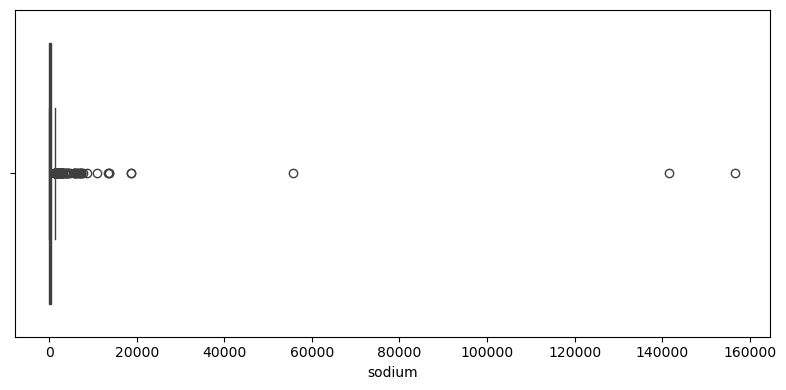

Distribución de 'potassium':
count      3760.000000
mean        931.274734
std       19586.756872
min           0.000000
25%          80.000000
50%         172.000000
75%         300.000000
max      925000.000000
Name: potassium, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/pre-sodium-potassium_boxplot_potassium.png


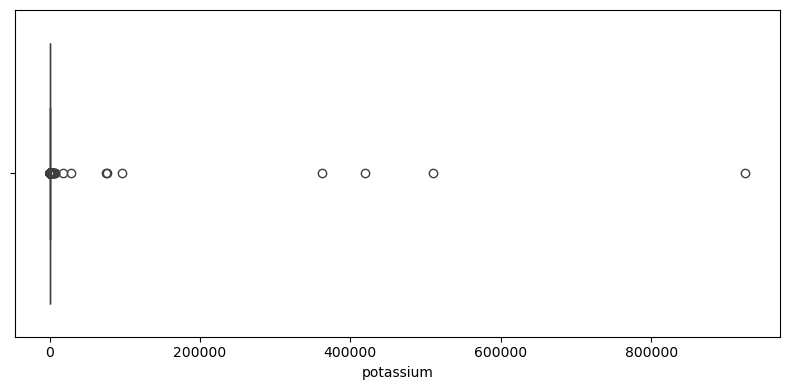

In [11]:
show_boxplots(foods, selected_cols, "pre-sodium-potassium")

In [12]:
# Obtener índices de outliers para cada columna
outliers_sodium_idx = detectar_outliers(foods, 'sodium')
outliers_potassium_idx = detectar_outliers(foods, 'potassium')
# Unión de índices de outliers
todos_outliers = outliers_sodium_idx.union(outliers_potassium_idx)
print(f"Número total de outliers (sodium o potassium): {len(todos_outliers)}")

# Eliminar outliers del DataFrame
foods_clean = foods.drop(index=todos_outliers)
print(f"Registros restantes tras eliminar outliers: {len(foods_clean)}")

Número total de outliers (sodium o potassium): 458
Registros restantes tras eliminar outliers: 3302


Distribución de 'sodium':
count    3302.000000
mean      283.440642
std       277.328623
min         0.000000
25%        42.000000
50%       220.000000
75%       450.750000
max      1228.000000
Name: sodium, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-sodium-potassium_boxplot_sodium.png


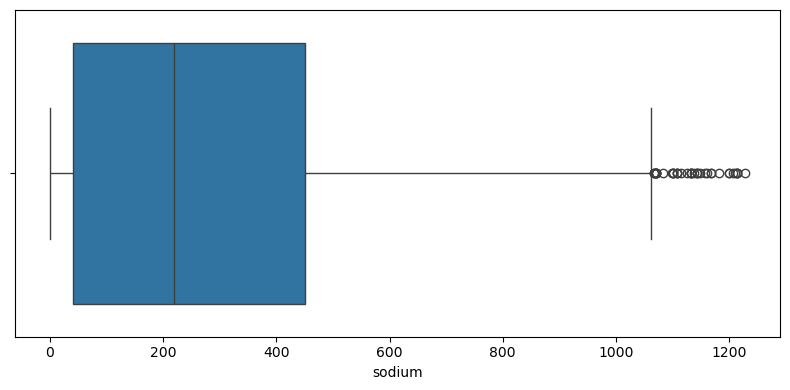

Distribución de 'potassium':
count    3302.000000
mean      176.479709
std       139.896666
min         0.000000
25%        72.250000
50%       157.500000
75%       246.000000
max       628.000000
Name: potassium, dtype: float64
----------------------------------------
Gráfico guardado en: ./out-resources/boxplots/post-sodium-potassium_boxplot_potassium.png


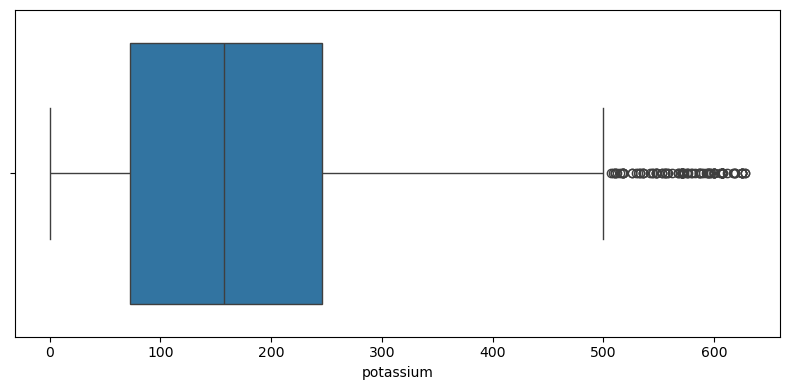

In [13]:
show_boxplots(foods_clean, selected_cols, "post-sodium-potassium")

In [14]:
# Función para contar los outliers
def contar_outliers(df, columna):
    Q1 = df[columna].quantile(0.25)  # Primer cuartil
    Q3 = df[columna].quantile(0.75)  # Tercer cuartil
    IQR = Q3 - Q1  # Rango intercuartílico

    # Definir los límites inferior y superior
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    # Identificar los outliers
    outliers = df[(df[columna] < limite_inferior) | (df[columna] > limite_superior)]

    return outliers

# Contar los outliers para 'calories' y 'protein'
outliers_sodium = contar_outliers(foods_clean, 'sodium')
outliers_potassium = contar_outliers(foods_clean, 'potassium')

# Imprimir el número de outliers
print(f"Número de outliers en 'sodium': {len(outliers_sodium)}")
print(f"Número de outliers en 'potassium': {len(outliers_potassium)}")

Número de outliers en 'sodium': 40
Número de outliers en 'potassium': 99


# K-means model

In [15]:
escalador = MinMaxScaler().fit(foods_clean.values)
foods_scaled = pd.DataFrame(escalador.transform(foods_clean.values), columns=selected_cols)

In [16]:
foods_scaled.head()

,sodium,potassium
0,0.071661,0.660828
1,0.359935,0.265924
2,0.495114,0.124204
3,0.000000,0.347134
4,0.037459,0.022293


In [17]:
kmeans = KMeans(n_clusters=6, n_init=10, random_state=42).fit(foods_scaled.values)
foods_scaled["cluster"] = kmeans.labels_

In [18]:
sil_kmeans = silhouette_score(foods_scaled.values, kmeans.labels_)
print('Silhouette Score', sil_kmeans)

Silhouette Score 0.8479456377346363


## Exportar modelo

In [19]:
import joblib

In [20]:
# Guardar el escalador
joblib.dump(escalador, "./models/sodium-potassium-minmax-scaler.pkl")

# Guardar el modelo KMeans
joblib.dump(kmeans, "./models/sodium-potassium-kmeans-model.pkl")

['./models/sodium-potassium-kmeans-model.pkl']

## Export clustering csv

In [21]:
# Preparar información para CSV
foods_info = df.loc[foods_clean.index, ['id', 'sodium', 'potassium']].copy()
foods_info['cluster'] = kmeans.labels_

# Limpiar saltos de línea en 'name'
#foods_info['name'] = foods_info['name'].str.replace(r'[\r\n]+', ' ', regex=True).str.strip()

# Exportar CSV
#foods_info.to_csv("./out-csv/sodium-potassium-clustering.csv", index=False)

## Data Analysis

In [22]:
# Resumen mínimos y máximos por cluster
min_max_summary = foods_info.groupby('cluster')[selected_cols].agg(['min', 'max'])
print(min_max_summary)

        sodium         potassium       
           min     max       min    max
cluster                                
0          0.0   432.0       0.0  120.0
1        229.0   655.0      42.0  335.0
2          0.0   487.0     297.0  628.0
3        446.0  1214.0       0.0  224.0
4        469.0  1228.0     231.0  628.0
5          0.0   228.0     106.0  308.0


In [23]:
# Conteo de registros por cluster
counts = foods_info['cluster'].value_counts().sort_index()
print("Conteo de registros por cluster:")
print(counts)

Conteo de registros por cluster:
cluster
0    751
1    705
2    408
3    447
4    177
5    814
Name: count, dtype: int64


## Clustering charts

Gráfico guardado como './out-resources/clustering/sodium-potassium.png'


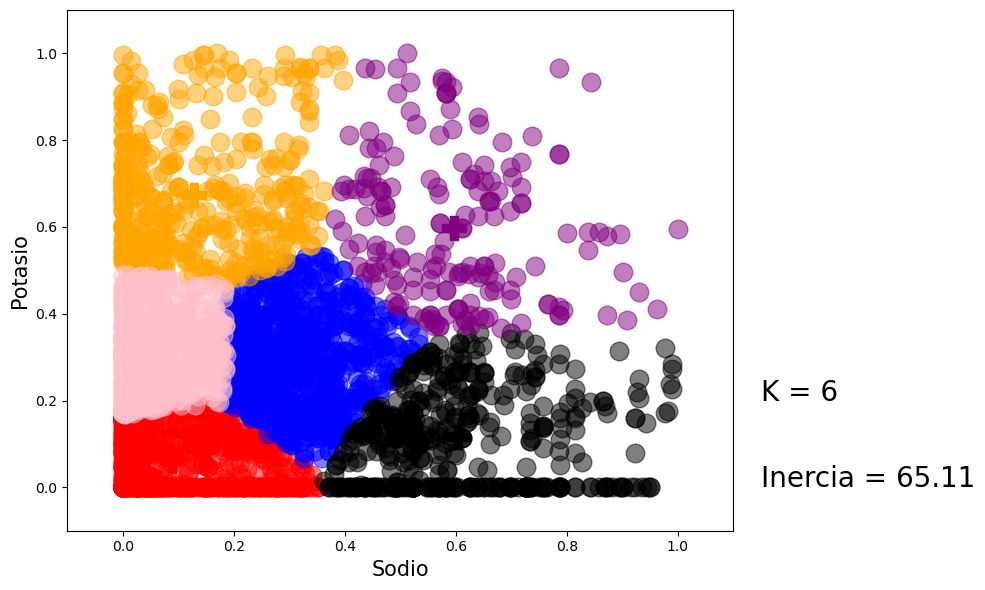

In [24]:
# Instrucciones para graficar los clusters

plt.figure(figsize=(10, 6), dpi=100)

colores = ["red", "blue", "orange", "black", "purple", "pink", "brown", "yellow"]

for cluster in range(kmeans.n_clusters):
    plt.scatter(foods_scaled[foods_scaled["cluster"] == cluster]["sodium"],
                foods_scaled[foods_scaled["cluster"] == cluster]["potassium"],
                marker="o", s=180, color=colores[cluster], alpha=0.5)

    plt.scatter(kmeans.cluster_centers_[cluster][0],
                kmeans.cluster_centers_[cluster][1],
                marker="P", s=280, color=colores[cluster])

# plt.title("Alimentos", fontsize=20)
plt.xlabel("Sodio", fontsize=15)
plt.ylabel("Potasio", fontsize=15)
plt.text(1.15, 0.2, "K = %i" % kmeans.n_clusters, fontsize=20)
plt.text(1.15, 0, "Inercia = %0.2f" % kmeans.inertia_, fontsize=20)
plt.xlim(-0.1, 1.1)
plt.ylim(-0.1, 1.1)
plt.tight_layout()

# Guardar la imagen
filename = "./out-resources/clustering/sodium-potassium.png"
plt.savefig(filename)
print(f"Gráfico guardado como '{filename}'")

plt.show()

del foods_scaled["cluster"]

# Método del Codo

Gráfico guardado como './out-resources/elbow_method/sodium-potassium.png'


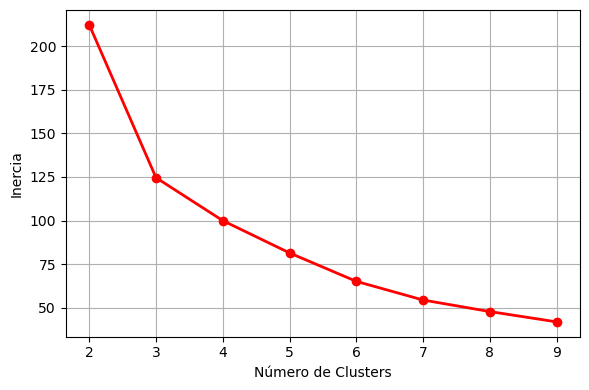

In [25]:
plot_elbow_method(foods_scaled, "sodium-potassium")